In [1]:
from physioex.train.models import load_model
from physioex.data import PhysioExDataModule
import visualization as vis
import emb_extraction as emb_ext

import os

In [2]:
# Note the best practice is to use a yaml file to store the arguments
# datamodule arguments

datamodule_kwargs = {
    "batch_size": 128,
    "selected_channels": ["EEG"],
    "sequence_length": 3,
    "target_transform": None, # needs to match model output
    "preprocessing": "xsleepnet", # needs to match model input
    "data_folder": "/mnt/guido-data/", # your custom path here
    "num_workers": os.cpu_count(), # default value
    #"num_workers": 1, # default value
    "concepts": False,
}

# let's use the standard approach to load the model, can be any SleepModule
# you can use it also in a .yaml file

model_class = "physioex.train.networks.ae_conv3d:AutoEncoderConv3D"

import importlib
module_name, class_name = model_class.split(":")
model_class = getattr(importlib.import_module(module_name), class_name)

# now we need to define the model parameters,
# these should be passed in the constructor of the model as a dictionary "model_config"

# first read the default parameters from physioex
from physioex.train.networks import config as networks_config
model_config = networks_config["default"]["model_kwargs"].copy()

# now we can modify the parameters as we want, first using the specific parameters for the model
if "model_kwargs" in networks_config["ae_conv3d"]:
    model_config.update(networks_config["ae_conv3d"]["model_kwargs"])

# now setup the ones that depends on the datamodule
model_config.update({
    "in_channels" : len(datamodule_kwargs["selected_channels"]),
    "sequence_length" : datamodule_kwargs["sequence_length"],
})

In [3]:
# load a trained model
checkpoint = "../models/ae/ae_conv3d_mass/fold=-1-epoch=14-step=24135-val_loss=0.78.ckpt"

model = load_model(
    model = model_class,
    model_kwargs = model_config,
    ckpt_path = checkpoint,
)

# load the dataloader that we want to extract the embeddings from (in this case the test dataloader of the mass dataset)
dataloader = PhysioExDataModule(datasets=["mass"], **datamodule_kwargs).test_dataloader()

In [4]:
# compute the embeddings

embeddings, labels = emb_ext.compute_embedding_autoencoder(model, dataloader)

100%|██████████| 86/86 [00:01<00:00, 64.49it/s]


Explained variance by component 1: 0.20
Explained variance by component 2: 0.11


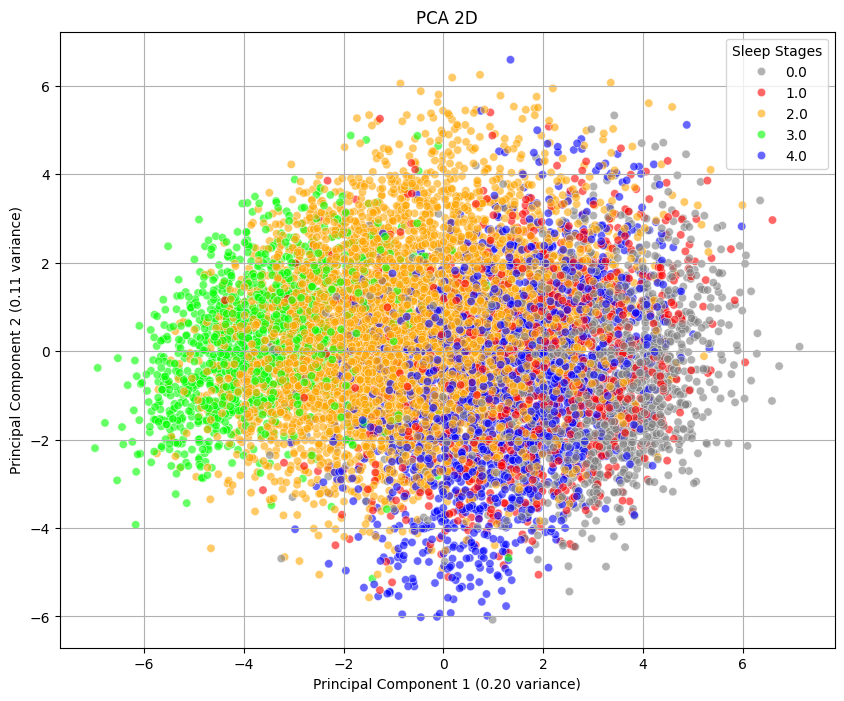

In [5]:
# plot the embeddings in 2D using PCA

vis.plot_pca_2d(embeddings, labels)

### Reconstruction Examples

In [6]:
mean = dataloader.dataset.readers[0].reader.mean.squeeze().numpy()
std = dataloader.dataset.readers[0].reader.std.squeeze().numpy()
denorm = (mean, std)

In [7]:
# check reconstruction examples (input vs reconstructed input)
inputs, labels = next(iter(dataloader))
emb, reconstructions = model(inputs.to(model.device))

In [8]:
spectrograms_to_plot = []
titles = ["Input", "Reconstruction"]
spectrograms_to_plot.append(inputs[0][0][0])
spectrograms_to_plot.append(reconstructions[0][0][0].to("cpu").detach())


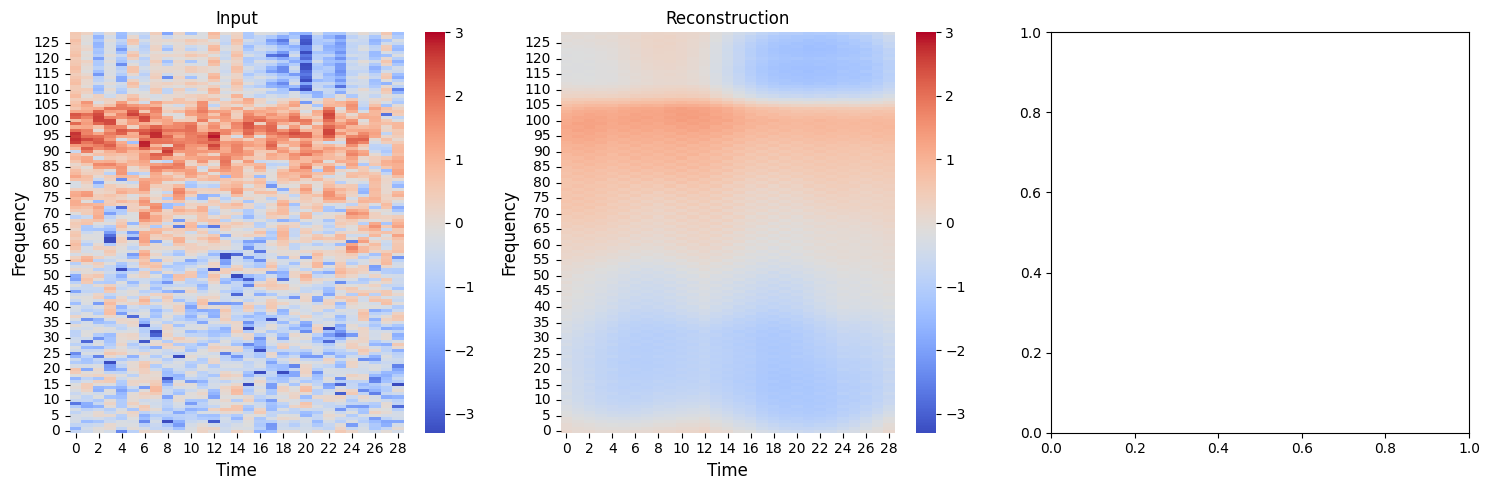

In [9]:
vis.plotSpectrograms(spectrograms_to_plot, titles, vmax=-3, vmin=3)

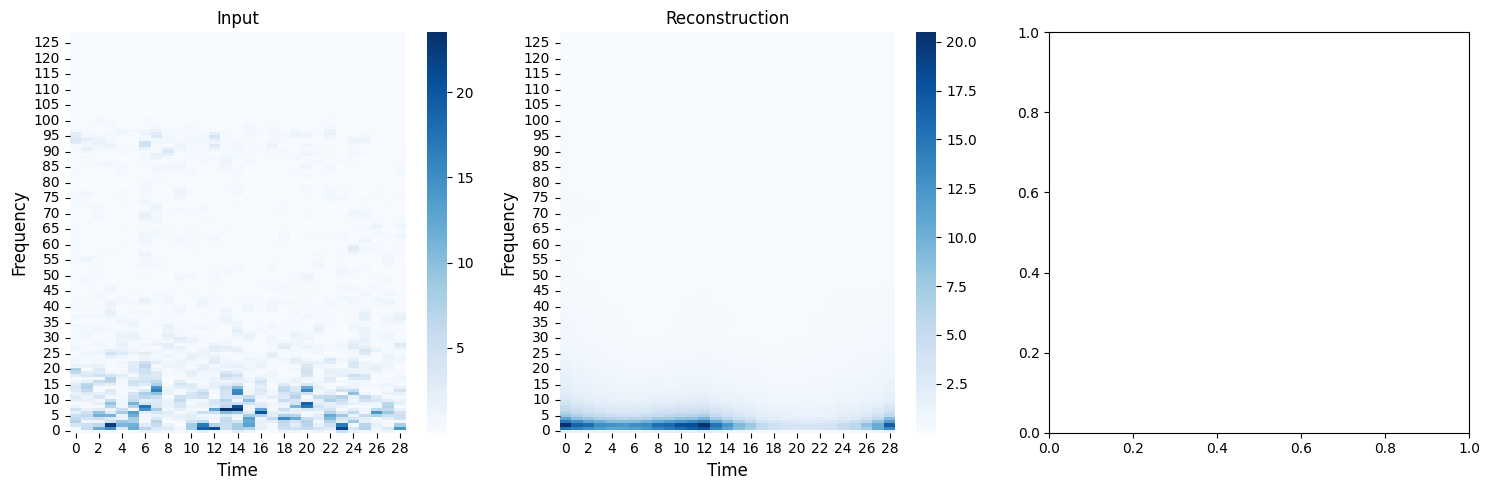

In [10]:
vis.plotSpectrograms(spectrograms_to_plot, titles, vmax=-3, vmin=3, denorm=denorm)